### Forecasting Future Bakery Daily Sales

In this project we will analyze a timeseries dataset and get to learn 
how to predict future values and evaluate the performance of our model.

In [1]:
#Start by importing the necessary dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from utilsforecast.plotting import plot_series #used to visuarize our timeseries
from utilsforecast.evaluation import evaluate  #used to evaluate the performance of selected models
from utilsforecast.losses import * #this are the metrics used to measure the performance of our model

from statsforecast import StatsForecast #The model that enables us to run our timeseries models
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive #This are some of the baseline model we will use for this project


import warnings
warnings.filterwarnings('ignore')

C:\Users\XL\anaconda3\envs\DSPractice\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load the data
df = pd.read_csv(r'daily_sales_french_bakery.csv')
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


## a) Data Cleaning

In [3]:
# Check quality of data
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 57046 entries, 0 to 57045
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unique_id   57046 non-null  str    
 1   ds          57046 non-null  str    
 2   y           57046 non-null  float64
 3   unit_price  57046 non-null  float64
dtypes: float64(2), str(2)
memory usage: 2.9 MB


In [4]:
# Convert ds from a string to datetime
df = pd.read_csv(r'daily_sales_french_bakery.csv', parse_dates = ['ds']) #define the dataset once more this time pass through parse_date
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 57046 entries, 0 to 57045
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   unique_id   57046 non-null  str           
 1   ds          57046 non-null  datetime64[us]
 2   y           57046 non-null  float64       
 3   unit_price  57046 non-null  float64       
dtypes: datetime64[us](1), float64(2), str(1)
memory usage: 2.4 MB


In [5]:
df.describe()

,ds,y,unit_price
count,57046,57046.000000,57046.000000
mean,2021-11-18 13:24:30.770957,9.792814,3.631011
min,2021-01-02 00:00:00,0.000000,0.000000
25%,2021-06-25 00:00:00,0.000000,1.400000
50%,2021-11-17 00:00:00,0.900000,2.000000
75%,2022-04-17 00:00:00,8.000000,4.500000
max,2022-09-30 00:00:00,919.100000,60.000000
std,NaN,32.327068,3.909706


Looking at column 'y'(our dependent variable in this case) we have 25% of our data with value 0.
this indicates no sales at 25% of our days. It is well represented data

In [6]:
df['y'].value_counts()

y
0.0     27892
6.0      1136
3.0      1053
4.0       762
12.0      739
        ...  
13.7        1
37.1        1
33.8        1
54.0        1
40.5        1
Name: count, Length: 1286, dtype: int64

In [7]:
df.shape # see no of rows and colums

(57046, 4)

In [8]:
df.duplicated().sum() #check for duplicte rows

np.int64(0)

In [9]:
df.isnull().sum() #count the number of missing values 

unique_id     0
ds            0
y             0
unit_price    0
dtype: int64

In [10]:
df['unique_id'].value_counts() # A unique_id stands for a unique store

unique_id
BAGUETTE                  637
BANETTE                   637
BANETTINE                 637
BOULE 200G                637
BOULE 400G                637
                         ... 
REDUCTION SUCREES 24        1
SACHET DE VIENNOISERIE      1
TARTELETTE COCKTAIL         1
TROIS CHOCOLAT              1
TULIPE                      1
Name: count, Length: 148, dtype: int64

We have unique stores that have recorded 637 entries while some stores have 1 entry only. I will drop the other stores, only keep the ones with more than 600 entries

In [10]:
df = df.groupby('unique_id').filter(lambda x: len(x) >= 100)
df.groupby('unique_id').count()

,ds,y,unit_price
unique_id,,,
BAGUETTE,637,637,637
BAGUETTE APERO,526,526,526
BAGUETTE GRAINE,631,631,631
BANETTE,637,637,637
BANETTINE,637,637,637
...,...,...,...
TRAITEUR,447,447,447
TRIANGLES,362,362,362
TROPEZIENNE,553,553,553


In [11]:
df.shape #34715 

(56246, 4)

## b) Exploratory Data Analysis

In [14]:
# Pick 4 unique ids for visuals

ids = ['TRIANGLES',
       'VIK BREAD',
       'TARTELETTE',
       'PAIN',
          ]
           

In [15]:
# We look at unit_price later when running modelling with exogenous variables

df = df.drop(['unit_price'], axis=1)
df.columns

Index(['unique_id', 'ds', 'y'], dtype='str')

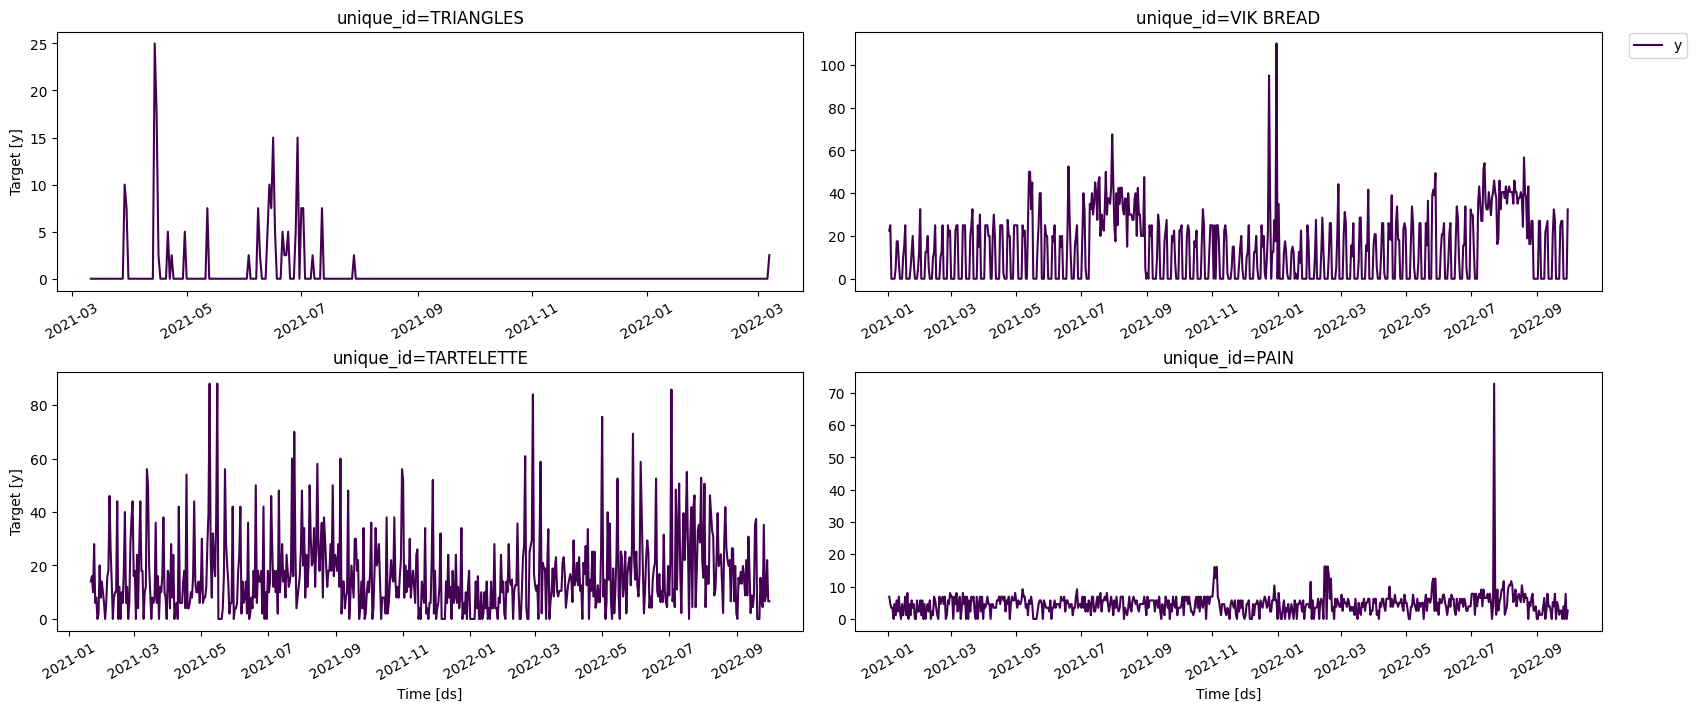

In [16]:
# plot the timeseries of our outlets
plot_series(
    df=df,
    ids=ids,
    palette = 'viridis'
    
)

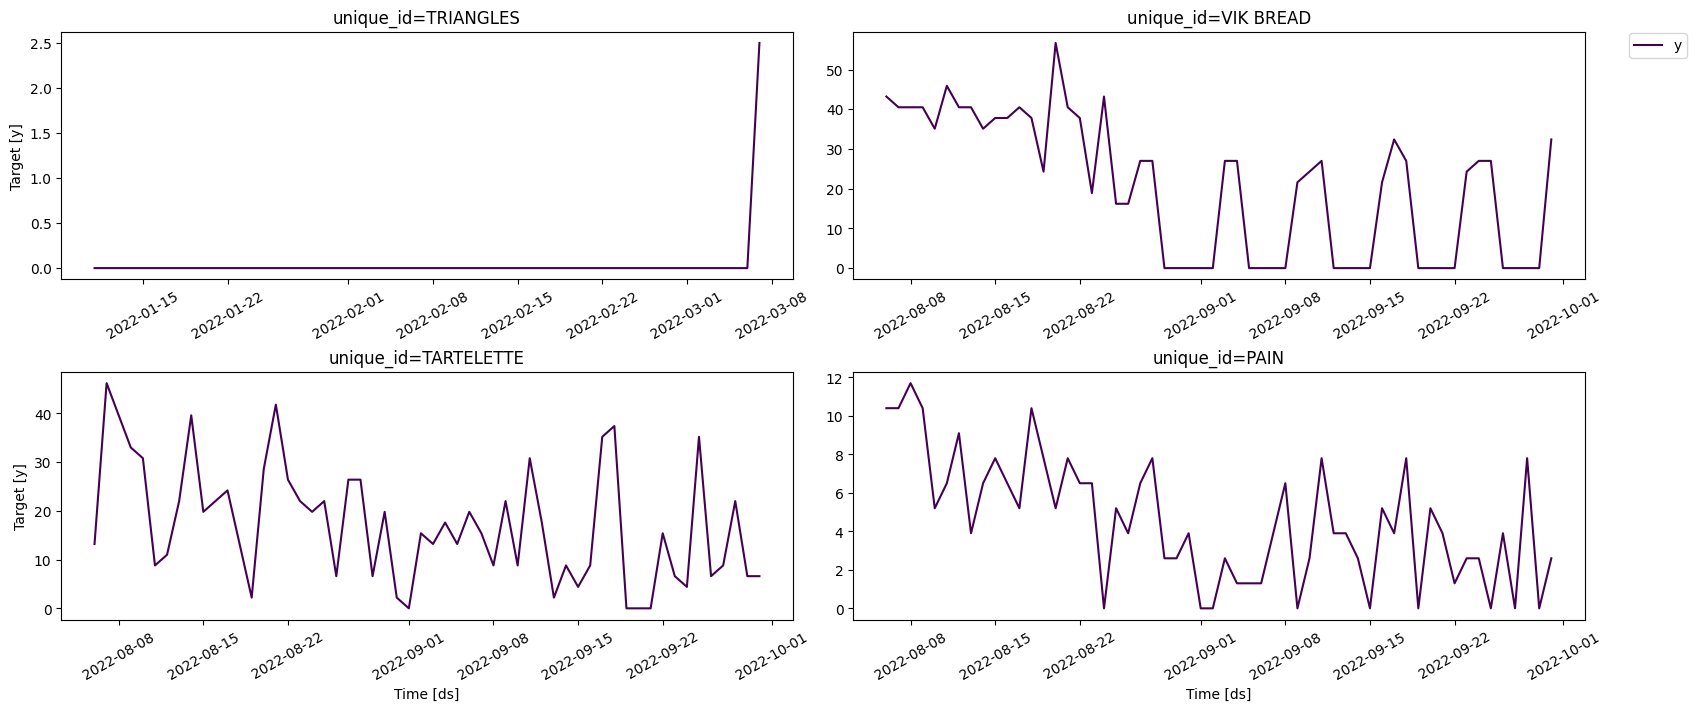

In [17]:
#Zoom in to the last 56 entries for a better view
# plot the timeseries of our outlets
plot_series(
    df=df,
    ids=ids,
    palette = 'viridis',
    max_insample_length = 56,
    
)

## c) BaseLIne Forecasting Models

In [18]:
# Run and evaluate out baseline models
# StatsForecast allow us to run multiple models at the same time

horizon = 7

models = [  Naive(), 
            HistoricAverage(), 
            WindowAverage(window_size=7), 
            SeasonalNaive(season_length=7),
]

#Run stats foresast

sf = StatsForecast(
    models = models,
    freq = 'D'
)

sf.fit(df=df)

preds = sf.predict(h=horizon)

preds.head()


,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,2022-10-01,35.0,32.152904,29.142857,28.0
1,BAGUETTE,2022-10-02,35.0,32.152904,29.142857,36.0
2,BAGUETTE,2022-10-03,35.0,32.152904,29.142857,18.0
3,BAGUETTE,2022-10-04,35.0,32.152904,29.142857,34.0
4,BAGUETTE,2022-10-05,35.0,32.152904,29.142857,23.0


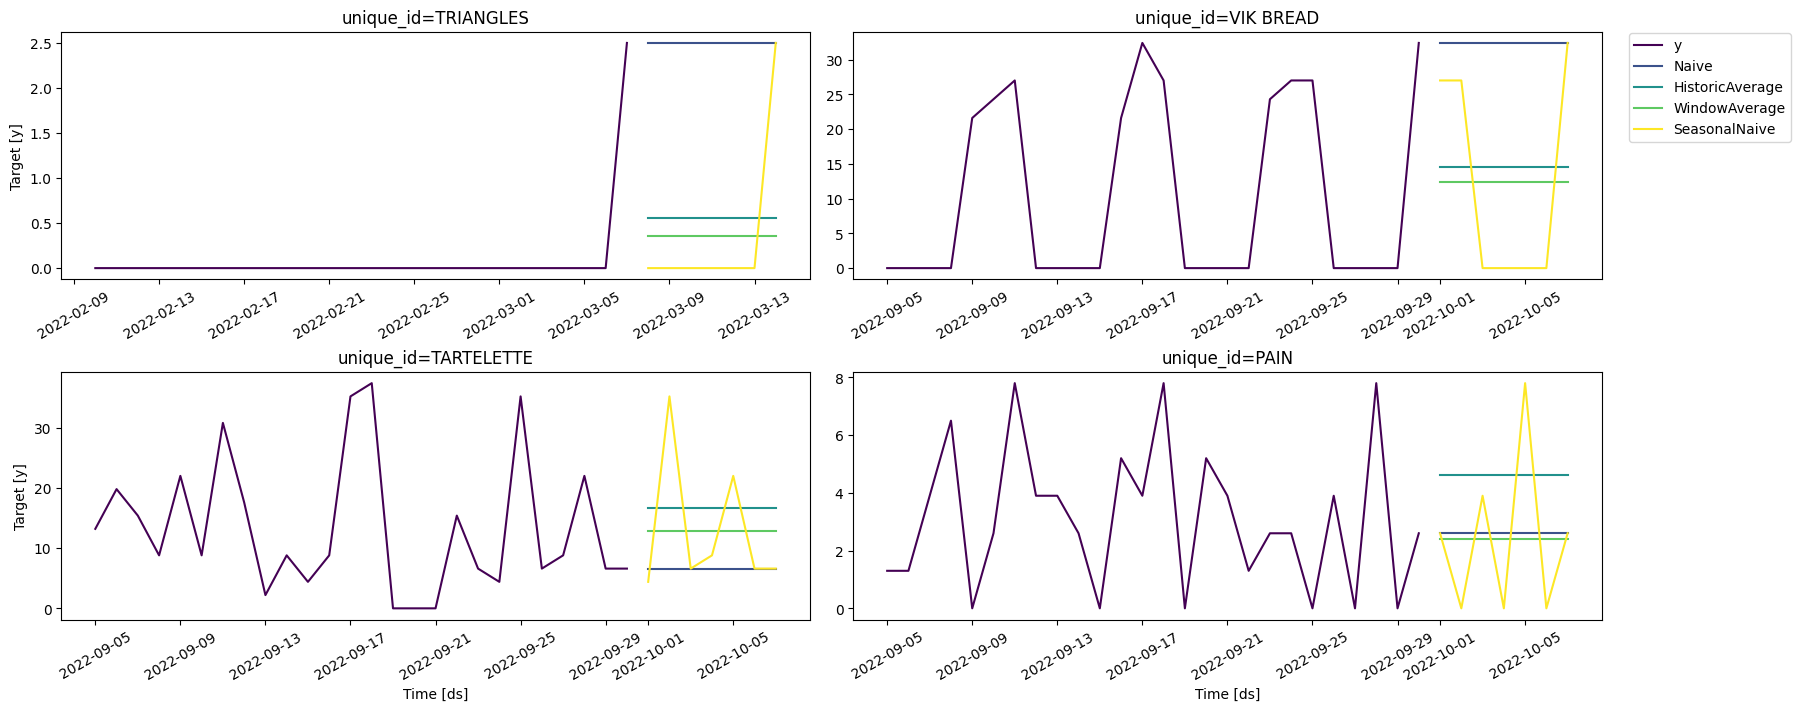

In [19]:
# Visualize the forecasts made

plot_series(
    df=df,
    forecasts_df = preds,
    ids=ids,
    palette = 'viridis',
    max_insample_length = 26,
    
)

## d) Evaluate the Baseline Models

In [21]:
# Split df into train and test sets
# Test set will have the last 14 days of our records

horizon = 21

test = df.groupby('unique_id').tail(21)
train = df.drop(test.index).reset_index(drop= True)

In [22]:
#fit the model

sf.fit(df=train)

preds = sf.predict(h = horizon)

# Merge the test set and the prediction made

eval_df = test.merge(preds, on = ['unique_id', 'ds'], how = 'inner')

eval_df.head()

,unique_id,ds,y,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,2022-09-10,31.0,25.0,32.339935,26.285714,38.0
1,BAGUETTE,2022-09-11,41.0,25.0,32.339935,26.285714,43.0
2,BAGUETTE,2022-09-12,26.0,25.0,32.339935,26.285714,21.0
3,BAGUETTE,2022-09-13,27.0,25.0,32.339935,26.285714,19.0
4,BAGUETTE,2022-09-14,22.0,25.0,32.339935,26.285714,18.0


In [23]:
# Evaluate the performance 

evaluation = evaluate(
    eval_df,
    metrics = [mae, mse]
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,8.238095,8.970455,7.986395,7.428571
1,BAGUETTE APERO,mae,0.214286,0.706082,0.795918,0.857143
2,BAGUETTE GRAINE,mae,6.533333,4.387198,2.247619,0.533333
3,BANETTE,mae,7.885714,9.596096,7.103401,7.885714
4,BANETTINE,mae,0.900000,0.923964,0.819048,1.066667


In [24]:
# Find the average of the scores over the whole dataset

evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,7.725064,5.554893,5.691961,5.199469
1,mse,277.982724,166.463002,161.277360,190.131234


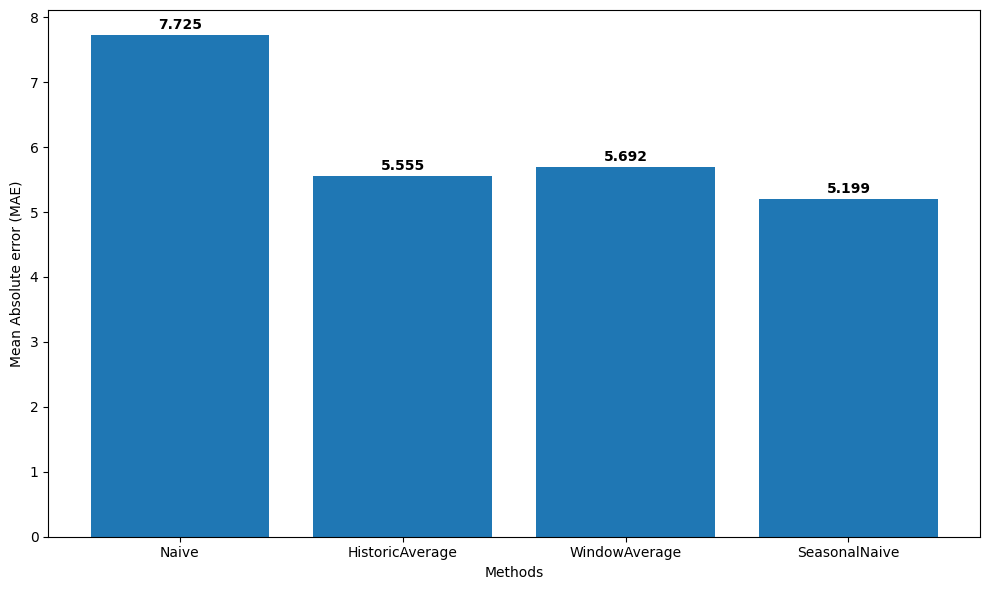

In [25]:
# Visualize the mae in a bar chart
#Visualize the performance in a bar graph
methods = evaluation.columns[1:].tolist()
values = evaluation.iloc[0, 1:].tolist()

plt.figure(figsize=(10,6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
plt.xlabel('Methods')
plt.ylabel('Mean Absolute error (MAE)')
plt.tight_layout()
plt.show()

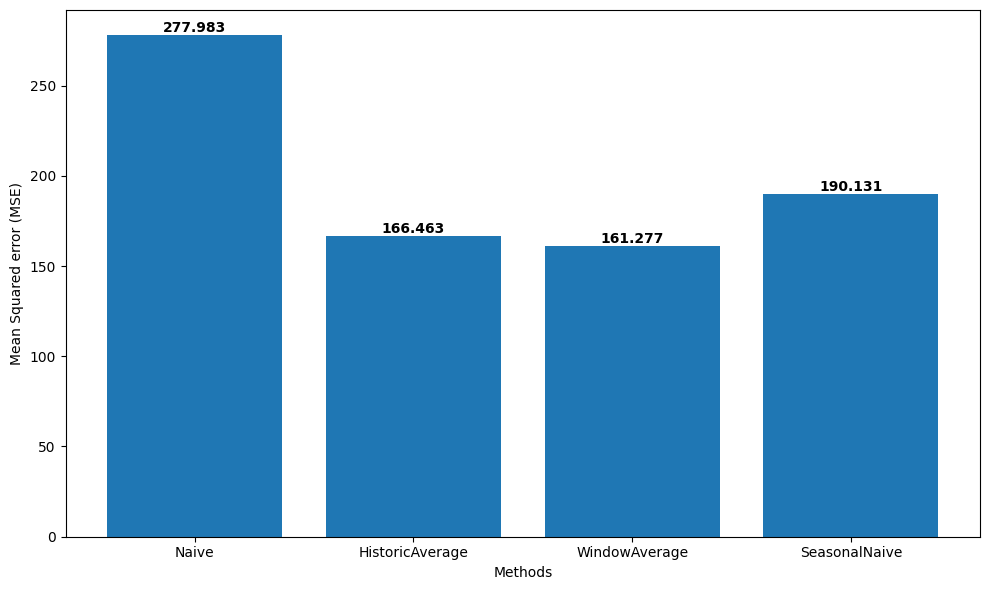

In [26]:
# Visualize the mse in a bar chart

methods = evaluation.columns[1:].tolist()
values = evaluation.iloc[1, 1:].tolist()

plt.figure(figsize=(10,6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
plt.xlabel('Methods')
plt.ylabel('Mean Squared error (MSE)')
plt.tight_layout()
plt.show()

In both of the metrics, it can be seen that Seasonal Naive is the best performer with a minimal error.
This means that our data is seasonal and a more advanced seasonal forecasting model will perform better than other models

## e) Statistical Models

AutoARIMA enables the optimization of ARIMA parameters so that we do not have to choose the parameters ourselves

In [27]:
from statsforecast.models import AutoARIMA


In [28]:
# Narrow our train and test sets to only include the 5 uniqued_ids we selected earlier
small_train = train[train['unique_id'].isin(ids)]
small_test = test[test['unique_id'].isin(ids)]

# Here we will try out  ARIMA and SARIMA models

models = [
    AutoARIMA(seasonal= False, alias='Arima'),
    AutoARIMA(season_length=7, alias ='SARIMA')
    
]

sf = StatsForecast(models = models, freq = "D")
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds', 'unique_id']) #inner join will ensure we get data of the unique_ids we selected earlier
arima_eval_df

,unique_id,ds,Arima,SARIMA,y,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,PAIN,2022-09-10,4.394213,5.552005,2.6,0.0,4.676380,2.414286,2.6
1,PAIN,2022-09-11,4.394213,5.349433,7.8,0.0,4.676380,2.414286,1.3
2,PAIN,2022-09-12,4.394213,4.995387,3.9,0.0,4.676380,2.414286,1.3
3,PAIN,2022-09-13,4.394213,4.897076,3.9,0.0,4.676380,2.414286,1.3
4,PAIN,2022-09-14,4.394213,4.913266,2.6,0.0,4.676380,2.414286,3.9
...,...,...,...,...,...,...,...,...,...
79,VIK BREAD,2022-09-26,10.021390,20.234284,0.0,21.6,14.668182,10.800000,0.0
80,VIK BREAD,2022-09-27,3.463920,14.659700,0.0,21.6,14.668182,10.800000,0.0
81,VIK BREAD,2022-09-28,2.120806,17.541841,0.0,21.6,14.668182,10.800000,0.0
82,VIK BREAD,2022-09-29,6.881030,18.157458,0.0,21.6,14.668182,10.800000,0.0


In [29]:
# Evaluate the performance of the models

arima_eval = evaluate(
    arima_eval_df, 
    metrics = [mae, mse]
)

arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()

arima_eval





,metric,Arima,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,5.162300,6.026000,8.034524,7.072158,6.580952,3.952381
1,mse,57.542787,72.962819,132.771071,90.667307,85.922279,47.854524


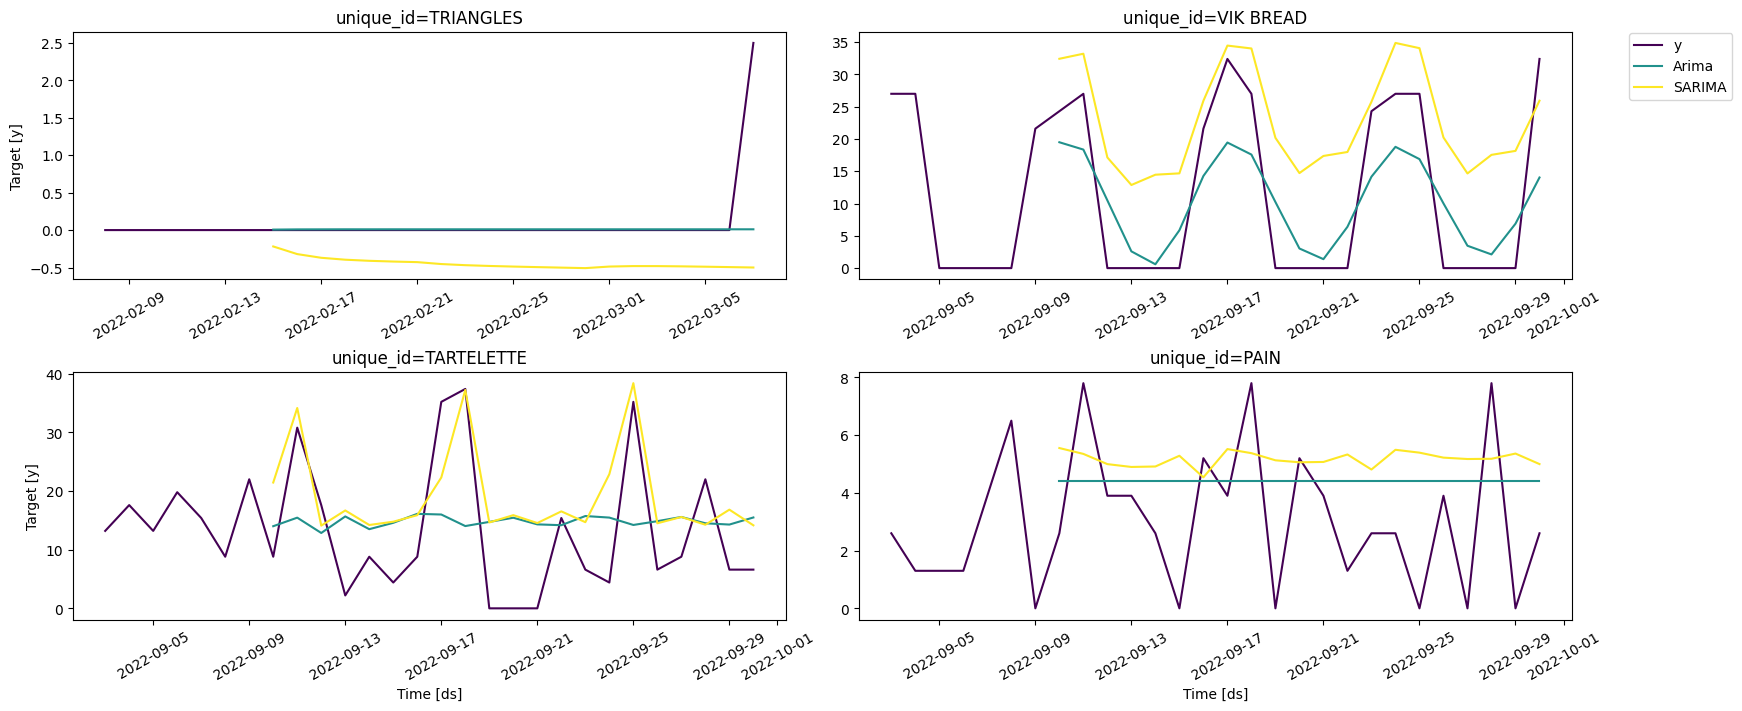

In [30]:
#Visualize the forecast

plot_series(
    df=df,
    forecasts_df = arima_preds,
    ids = ids,
    max_insample_length=28,
    palette = "viridis")

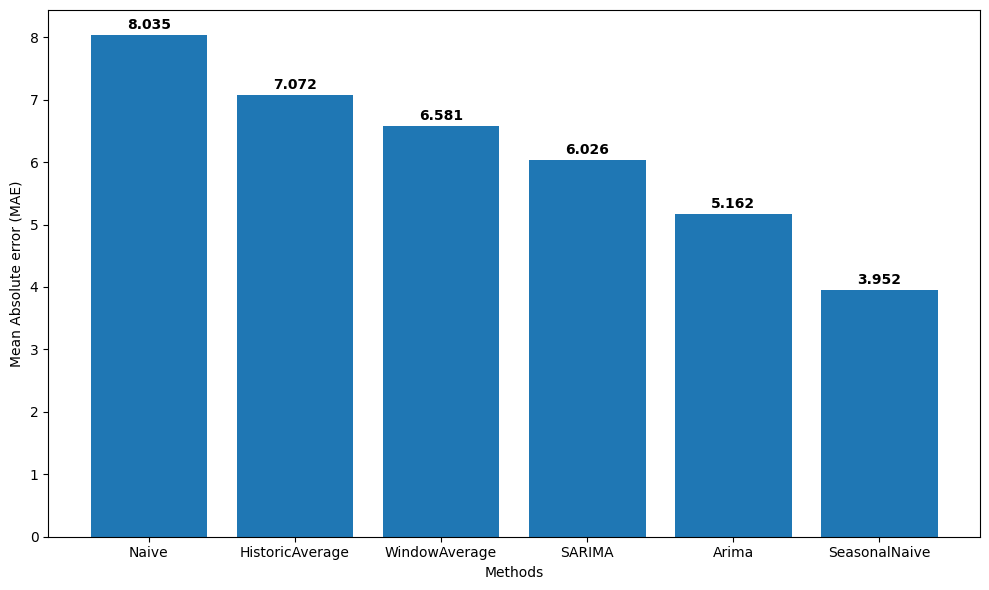

In [31]:
# Visualize the performance of the models in a bar chart
# Show the mae

methods = arima_eval.columns[1:].tolist()
values = arima_eval.iloc[0, 1:].tolist()

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10,6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
plt.xlabel('Methods')
plt.ylabel('Mean Absolute error (MAE)')
plt.tight_layout()
plt.show()



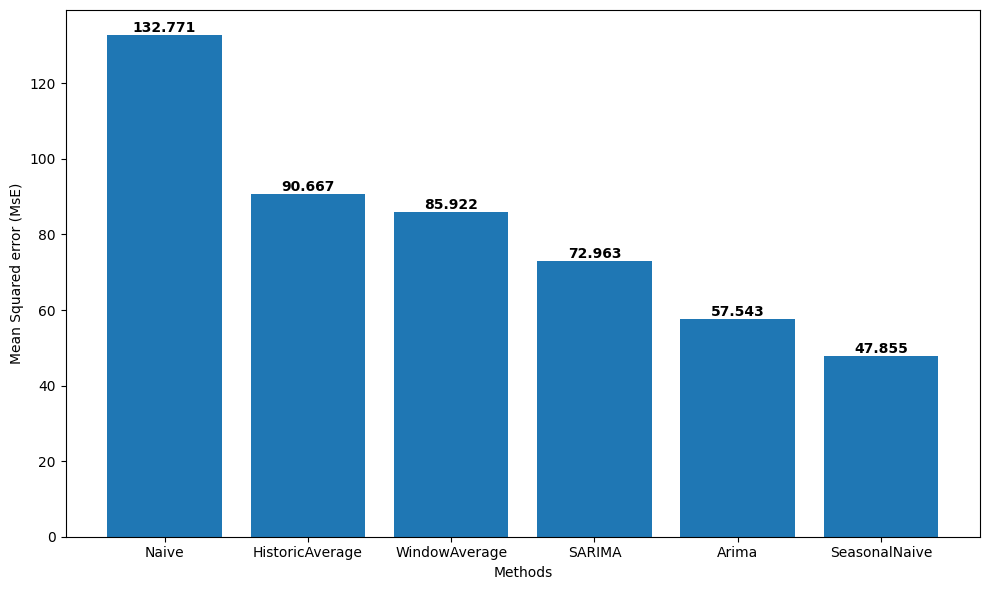

In [34]:
# Show the mse

methods = arima_eval.columns[1:].tolist()
values = arima_eval.iloc[1, 1:].tolist()

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)


plt.figure(figsize=(10,6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
plt.xlabel('Methods')
plt.ylabel('Mean Squared error (MsE)')
plt.tight_layout()
plt.show()

 Our baseline model SeasonalNaive persist in being the best forecaster

## f) Cross Validation

Conduct cross validation to check if the strengths of our models persist

In [35]:
small_df = df[df['unique_id'].isin(ids)]
small_df.shape

(2254, 3)

In [36]:
# We will include our 3 best models
models = [
    SeasonalNaive(season_length = 7),
    AutoARIMA(seasonal= False, alias='Arima'),
    AutoARIMA(season_length = 7, alias = "SARIMA")
]

sf = StatsForecast(models=models, freq = "D")

cv_df = sf.cross_validation(
    h= horizon,
    df= small_df,
    n_windows = 8,
    step_size = horizon, #helps to avoid screen overlapping
    refit = True
)

cv_df.head()

,unique_id,ds,cutoff,y,SeasonalNaive,Arima,SARIMA
0,PAIN,2022-04-16,2022-04-15,10.00,6.25,5.249581,5.548902
1,PAIN,2022-04-17,2022-04-15,3.75,6.25,5.008663,5.509255
2,PAIN,2022-04-18,2022-04-15,6.25,3.75,4.581693,4.202462
3,PAIN,2022-04-19,2022-04-15,3.75,2.50,4.358393,4.039998
4,PAIN,2022-04-20,2022-04-15,5.00,6.25,4.358393,4.170784


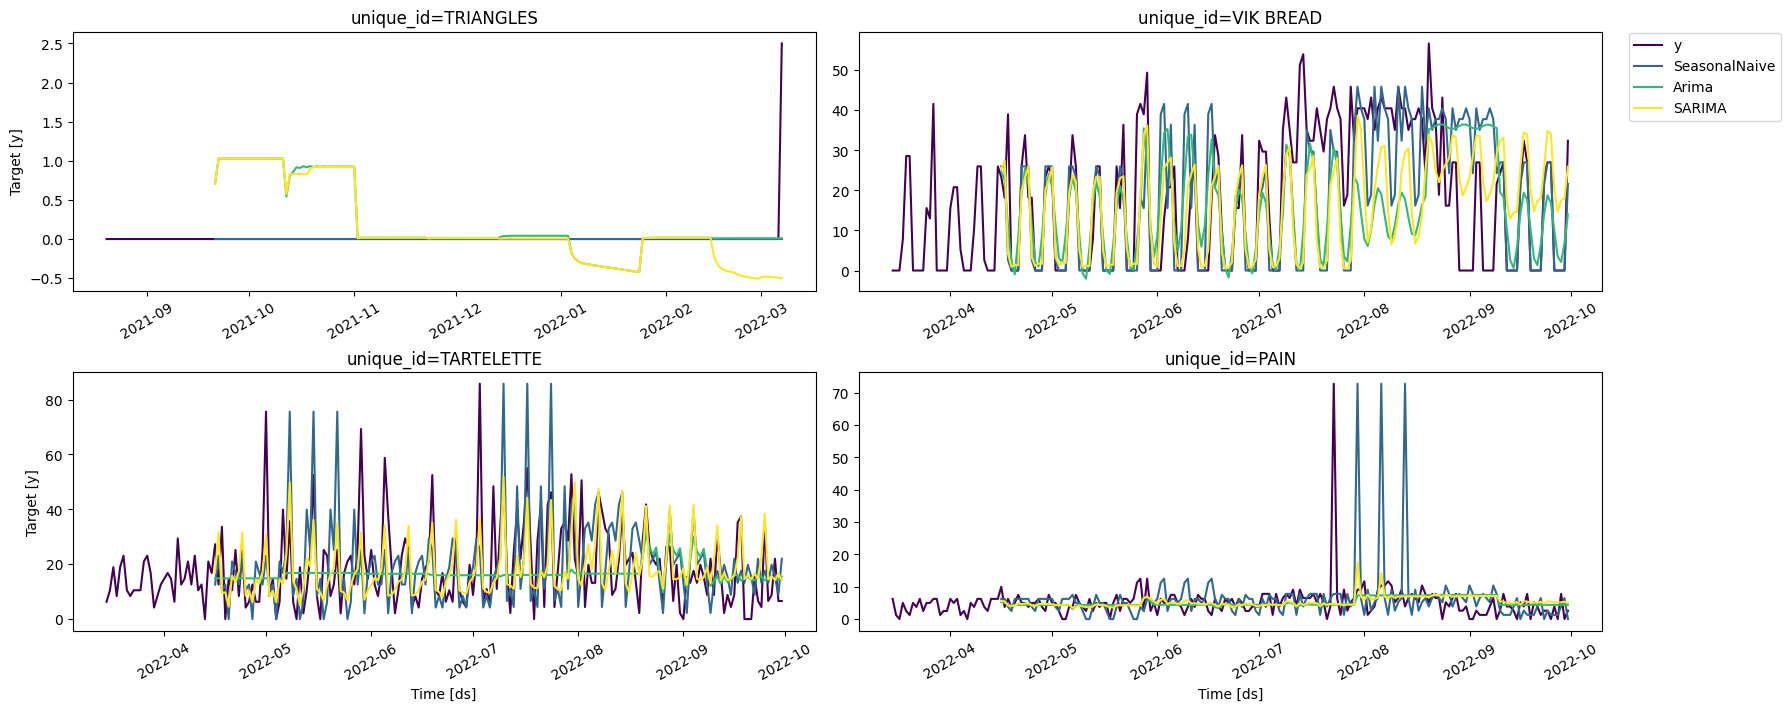

In [37]:
# Look at the forecast in a visual

plot_series(
    df= small_df,
    forecasts_df = cv_df.drop(['y', 'cutoff'], axis=1),
    ids = ids,
    max_insample_length = 200,
    palette = 'viridis'

)

In [38]:
# Evaluate the cv model 

cv_evaluation = evaluate(
    df= cv_df.drop(['cutoff'], axis=1),
    metrics = [mae, mse]
)

cv_evaluation = cv_evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_evaluation.head()

,metric,SeasonalNaive,Arima,SARIMA
0,mae,7.123140,7.080026,6.225457
1,mse,175.309602,150.348100,114.725072


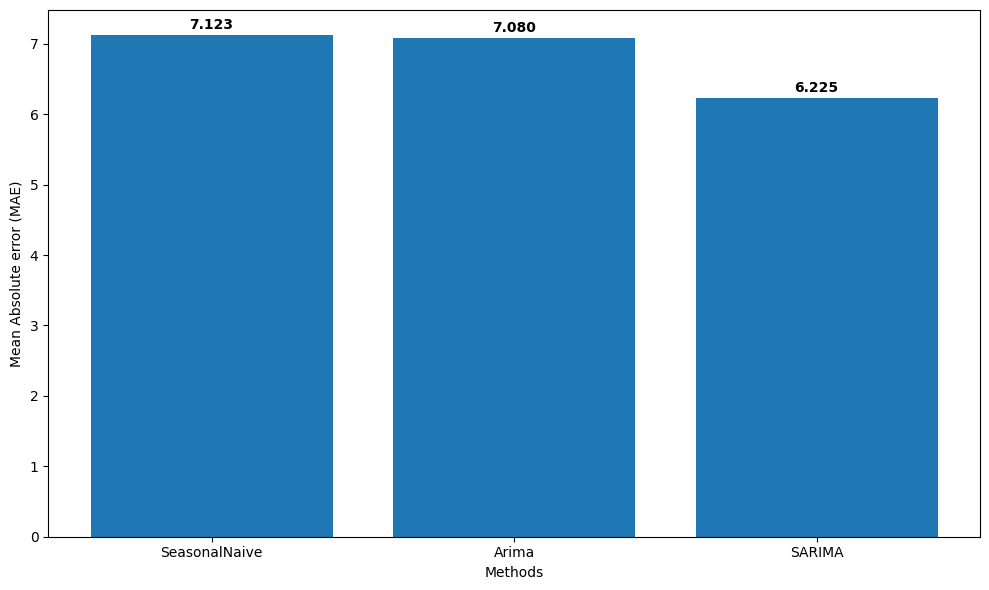

In [39]:
# Show the mae

methods = cv_evaluation.columns[1:].tolist()
values = cv_evaluation.iloc[0, 1:].tolist()

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10,6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
plt.xlabel('Methods')
plt.ylabel('Mean Absolute error (MAE)')
plt.tight_layout()
plt.show()

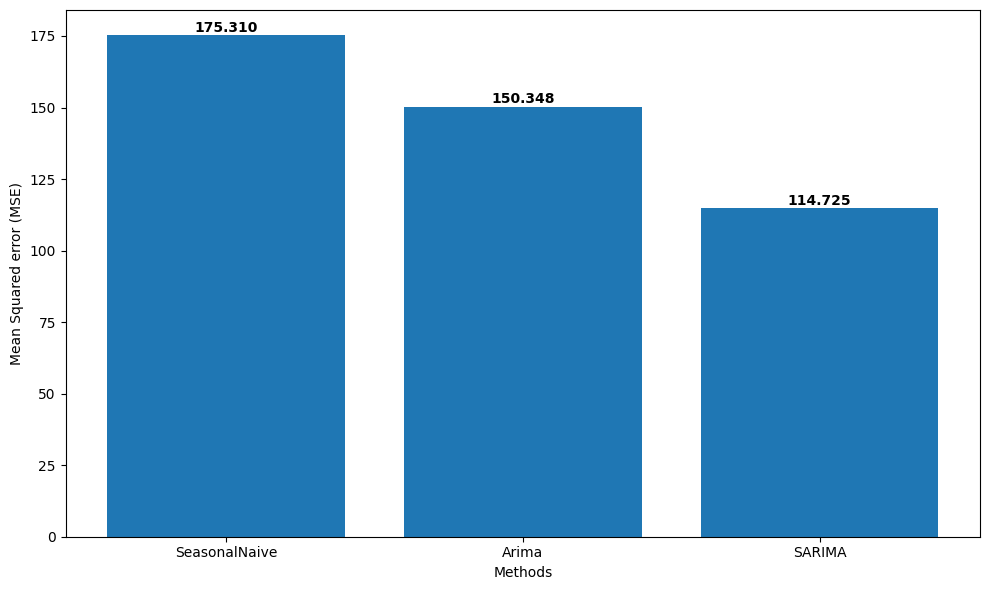

In [40]:
# Show the mse

methods = cv_evaluation.columns[1:].tolist()
values = cv_evaluation.iloc[1, 1:].tolist()

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)


plt.figure(figsize=(10,6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
plt.xlabel('Methods')
plt.ylabel('Mean Squared error (MSE)')
plt.tight_layout()
plt.show()

SeasonalNaive losses it's power to SARIMA.
After Cross Validation SARIMA stands out as the best performer

## g) Forecasting with Exogenous Features

In [41]:
#import the data once again, this time we will need all columns

df = pd.read_csv(r'daily_sales_french_bakery.csv', parse_dates= ['ds'])
df = df.groupby('unique_id').filter(lambda x: len(x) >=600)
df.shape

(34715, 4)

In [42]:
df.info()

<class 'pandas.DataFrame'>
Index: 34715 entries, 84 to 57045
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   unique_id   34715 non-null  str           
 1   ds          34715 non-null  datetime64[us]
 2   y           34715 non-null  float64       
 3   unit_price  34715 non-null  float64       
dtypes: datetime64[us](1), float64(2), str(1)
memory usage: 1.7 MB


In [43]:
df.head()

,unique_id,ds,y,unit_price
84,BAGUETTE,2021-01-02,41.4,0.9
85,BAGUETTE,2021-01-03,31.5,0.9
86,BAGUETTE,2021-01-04,27.0,0.9
87,BAGUETTE,2021-01-05,26.1,0.9
88,BAGUETTE,2021-01-06,0.0,0.9


In this case 'unit_price' will be our exogenous variable

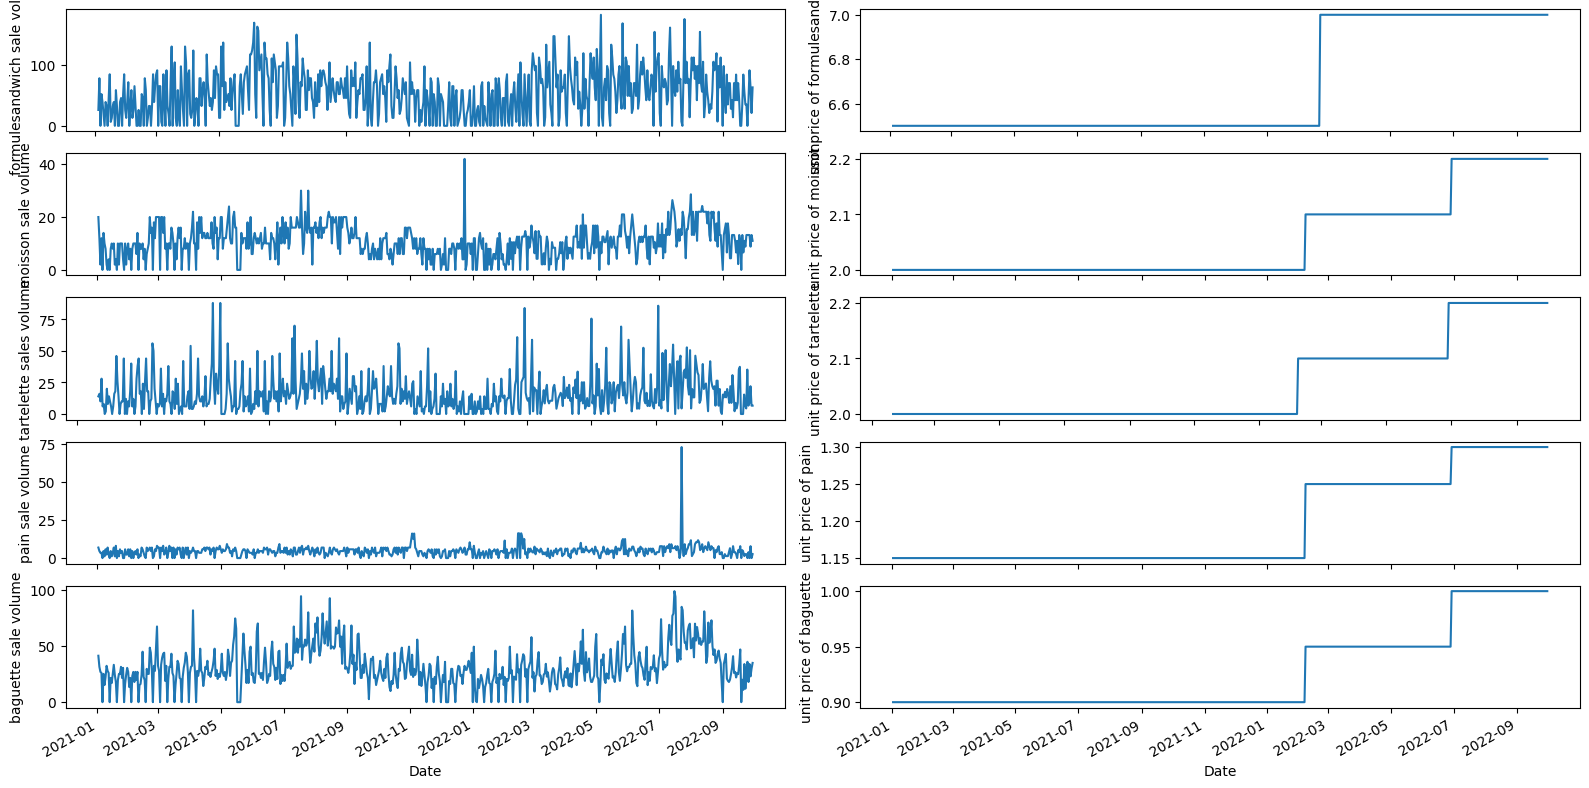

In [44]:
# Make a table of unique ids and show the relationship of y and other variables
         
formulesandwich_df = df[df['unique_id']== 'FORMULE SANDWICH']
moisson_df = df[df['unique_id']== 'MOISSON']
tartelette_df = df[df['unique_id']== 'TARTELETTE']
pain_df = df[df['unique_id']== 'PAIN']
baguette_df = df[df['unique_id']== 'BAGUETTE']


fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6),( ax7, ax8), (ax9, ax10)) = plt.subplots(nrows=5, ncols=2, figsize=(16,8))

ax1.plot(formulesandwich_df['ds'], formulesandwich_df['y'])
ax1.set_xlabel("Date")
ax1.set_ylabel("formulesandwich sale volume")


ax2.plot(formulesandwich_df['ds'], formulesandwich_df['unit_price'])
ax2.set_xlabel("Date")
ax2.set_ylabel("unit price of formulesandwich")


ax3.plot(moisson_df['ds'], moisson_df['y'])
ax3.set_xlabel("Date")
ax3.set_ylabel("moisson sale volume")


ax4.plot(moisson_df['ds'],moisson_df['unit_price'])
ax4.set_xlabel("Date")
ax4.set_ylabel("unit price of moisson")

ax5.plot(tartelette_df['ds'], tartelette_df['y'])
ax5.set_xlabel("Date")
ax5.set_ylabel("tartelette sales volume")

ax6.plot(tartelette_df['ds'], tartelette_df['unit_price'])
ax6.set_xlabel("Date")
ax6.set_ylabel("unit price of tartelette")

ax7.plot(pain_df['ds'], pain_df['y'])
ax7.set_xlabel("Date")
ax7.set_ylabel("pain sale volume")


ax8.plot(pain_df['ds'], pain_df['unit_price'])
ax8.set_xlabel("Date")
ax8.set_ylabel("unit price of pain")

ax9.plot(baguette_df['ds'], baguette_df['y'])
ax9.set_xlabel("Date")
ax9.set_ylabel("baguette sale volume")


ax10.plot(baguette_df['ds'], baguette_df['unit_price'])
ax10.set_xlabel("Date")
ax10.set_ylabel("unit price of baguette")

fig.autofmt_xdate()
plt.tight_layout()

In [48]:
# filter our dataframe to only have the 5 unique ids, and split into train and test sets

small_df = df[df['unique_id'].isin(ids)]
test = small_df.groupby('unique_id').tail(21)
train = small_df.drop(test.index).reset_index(drop=True)

In [49]:
futr_exog_df = test.drop('y', axis = 1)
futr_exog_df.head()

,unique_id,ds,unit_price
34504,PAIN,2022-09-10,1.3
34505,PAIN,2022-09-11,1.3
34506,PAIN,2022-09-12,1.3
34507,PAIN,2022-09-13,1.3
34508,PAIN,2022-09-14,1.3


In [50]:
# Define the model

models = [AutoARIMA(season_length = 7, alias = "SARIMA_exog"),]

sf = StatsForecast(models = models, freq = 'D')
sf.fit(df=train)

#predict with exogenous featureas

arima_exog_preds = sf.predict(h= horizon, X_df = futr_exog_df)

#predict without exogenous features
models = [AutoARIMA(season_length = 7, alias = "SARIMA"),]

sf = StatsForecast(models = models, freq = "D")
sf.fit(df =train.drop(['unit_price'], axis = 1))
arima_preds = sf.predict(h=horizon)

arima_exog_preds.head()


,unique_id,ds,SARIMA_exog
0,PAIN,2022-09-10,4.883361
1,PAIN,2022-09-11,4.976264
2,PAIN,2022-09-12,4.639817
3,PAIN,2022-09-13,4.717269
4,PAIN,2022-09-14,5.131309


In [51]:
arima_preds.head()

,unique_id,ds,SARIMA
0,PAIN,2022-09-10,5.552005
1,PAIN,2022-09-11,5.349433
2,PAIN,2022-09-12,4.995387
3,PAIN,2022-09-13,4.897076
4,PAIN,2022-09-14,4.913266


In [52]:
# Merge the prediction to the test dataset
test_df = test.merge(arima_exog_preds, on= ['unique_id', 'ds'], how ="left").merge(arima_preds, on= ['unique_id', 'ds'], how ="left")

test_df.head()

,unique_id,ds,y,unit_price,SARIMA_exog,SARIMA
0,PAIN,2022-09-10,2.6,1.3,4.883361,5.552005
1,PAIN,2022-09-11,7.8,1.3,4.976264,5.349433
2,PAIN,2022-09-12,3.9,1.3,4.639817,4.995387
3,PAIN,2022-09-13,3.9,1.3,4.717269,4.897076
4,PAIN,2022-09-14,2.6,1.3,5.131309,4.913266


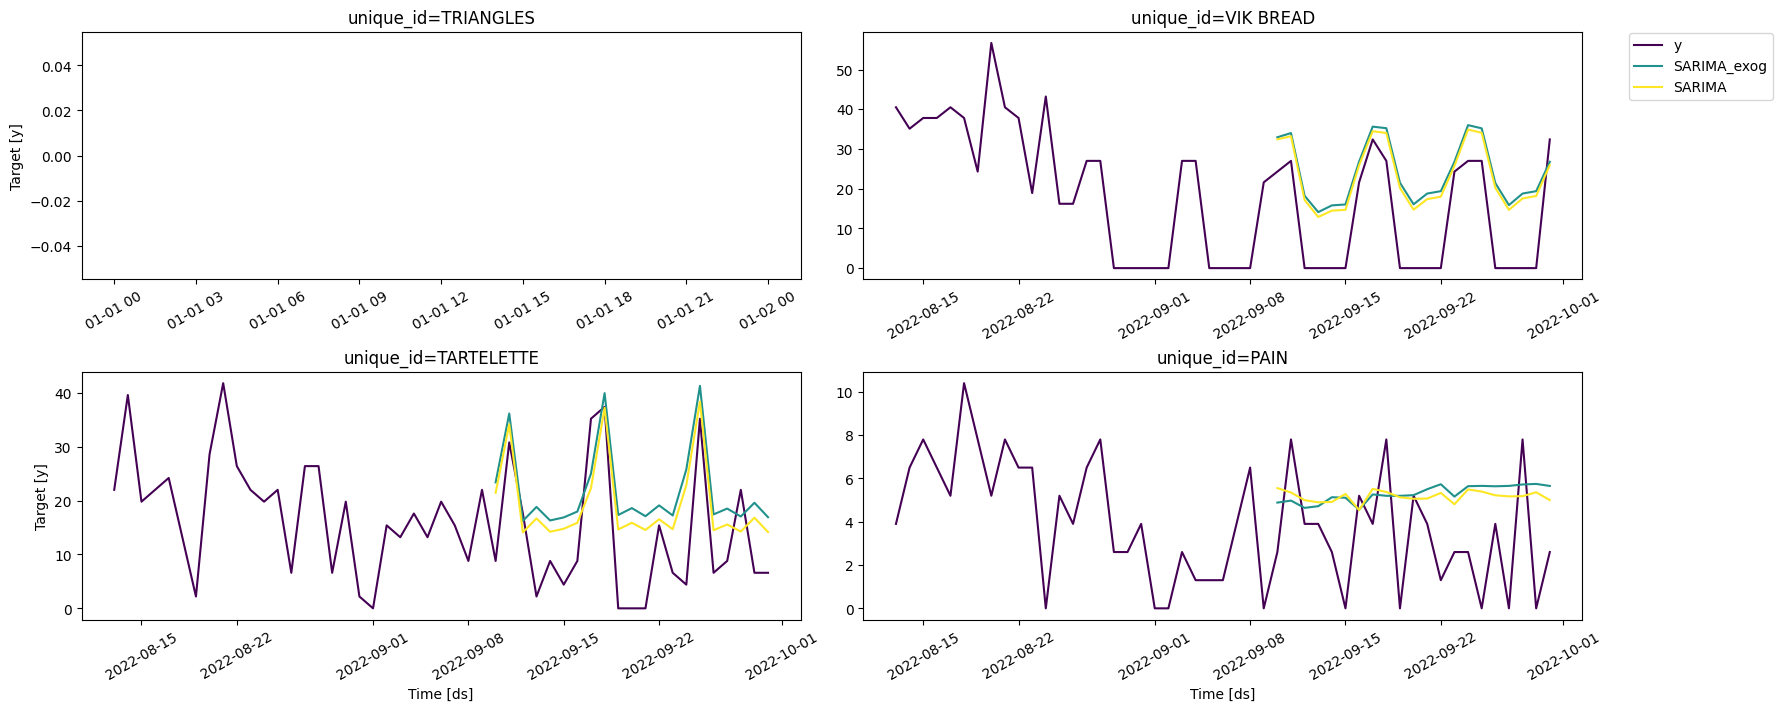

In [53]:
# Show the forecasts in a plot
plot_series(
    df=train,
    forecasts_df = test_df,
    ids = ids,
    max_insample_length = 28,
    models = ['SARIMA_exog', 'SARIMA'],
    palette = "viridis"

)

In [54]:
# Run cross validation on the SARIMA_exog model 

model = [AutoARIMA(season_length = 7, alias = "SARIMA_exog"),]

sf = StatsForecast(models = model, freq = 'D')

#Run Cross Validation now

cv_exog_df = sf.cross_validation(
    h = horizon,
    df = small_df,
    n_windows =8,
    step_size = horizon,
    refit = True
)

cv_exog_df.head()
    

,unique_id,ds,cutoff,y,SARIMA_exog
0,PAIN,2022-04-16,2022-04-15,10.00,5.678574
1,PAIN,2022-04-17,2022-04-15,3.75,5.655716
2,PAIN,2022-04-18,2022-04-15,6.25,4.372214
3,PAIN,2022-04-19,2022-04-15,3.75,4.236955
4,PAIN,2022-04-20,2022-04-15,5.00,4.361871


In [55]:
# Evaluate the performance

cv_exog_eval = evaluate(
    cv_exog_df.drop(['cutoff'], axis=1),
    metrics = [mae, mse],
)

cv_exog_eval = cv_exog_eval.drop(['unique_id'], axis =1).groupby('metric').mean().reset_index()
cv_exog_eval

,metric,SARIMA_exog
0,mae,8.095362
1,mse,144.646932


### Creatin Features from timestamps

In [56]:
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline

In [57]:
features = [
    partial(fourier, season_length=7, k=2),
    partial(time_features, features=["day", "week", "month"])
]

small_exog_df, futr_exog_df = pipeline(
    df= small_df,
    features = features,
    freq = "D",
    h=horizon
)

small_exog_df.head()

,unique_id,ds,y,unit_price,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
33888,PAIN,2021-01-02,6.90,1.15,0.781832,0.974928,0.623490,-0.222521,2,53,1
33889,PAIN,2021-01-03,4.60,1.15,0.974928,-0.433884,-0.222521,-0.900969,3,53,1
33890,PAIN,2021-01-04,3.45,1.15,0.433884,-0.781831,-0.900969,0.623490,4,1,1
33891,PAIN,2021-01-05,3.45,1.15,-0.433884,0.781832,-0.900969,0.623490,5,1,1
33892,PAIN,2021-01-06,0.00,1.15,-0.974928,0.433884,-0.222521,-0.900969,6,1,1


In [58]:
futr_exog_df.head()

,unique_id,ds,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
0,PAIN,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
1,PAIN,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
2,PAIN,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10
3,PAIN,2022-10-04,-0.433861,0.781800,-0.900980,0.623529,4,40,10
4,PAIN,2022-10-05,-0.974933,0.433846,-0.222500,-0.900987,5,40,10


In [59]:
# Run cross validation on the model 

model = [AutoARIMA(season_length = 7, alias = "SARIMA_time_exog"),]

sf = StatsForecast(models = model, freq = 'D')

#Run Cross Validation now

cv_time_exog_df = sf.cross_validation(
    h = horizon,
    df = small_exog_df,
    n_windows =8,
    step_size = horizon,
    refit = True
)

# Evaluate the performance

cv_time_exog_eval = evaluate(
    cv_time_exog_df.drop(['cutoff'], axis=1),
    metrics = [mae, mse],
)

cv_time_exog_eval = cv_time_exog_eval.drop(['unique_id'], axis =1).groupby('metric').mean().reset_index()
cv_time_exog_eval
    

,metric,SARIMA_time_exog
0,mae,7.966805
1,mse,138.337648


In [60]:
 # Visualize the performance of the models in a bar chart

methods = ["SeasonaNaive", "ARIMA", "SARIMA", "SARIMA_price_exog", "SARIMA_time_exog"]
values = [ 7.123140, 7.080026, 6.225457, 8.095362, 7.966805]

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

methods_sorted



('SARIMA_price_exog', 'SARIMA_time_exog', 'SeasonaNaive', 'ARIMA', 'SARIMA')

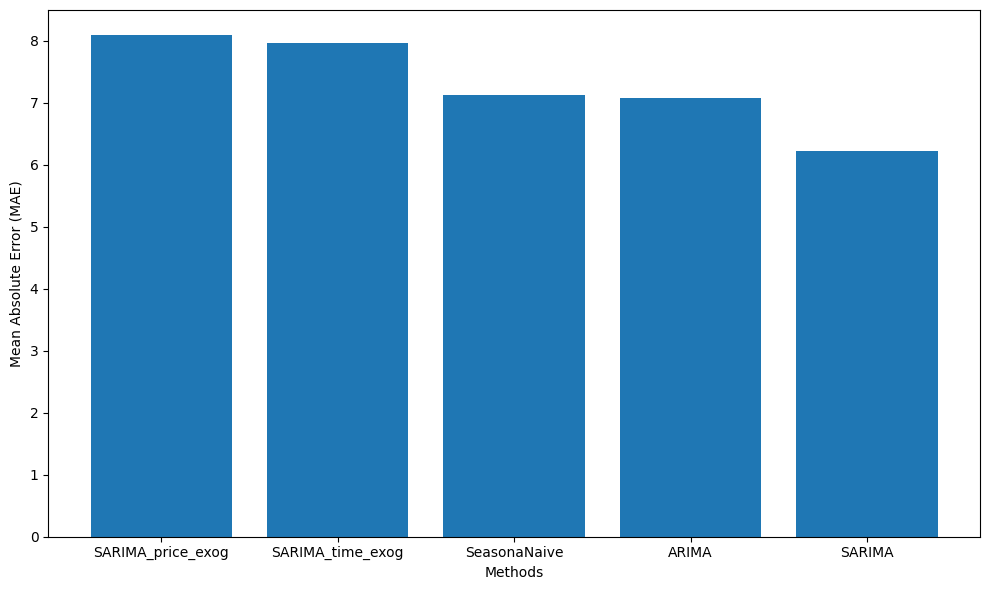

In [61]:
plt.figure(figsize = (10, 6))
bars = plt.bar(methods_sorted, values_sorted)

    
plt.xlabel('Methods')
plt.ylabel('Mean Absolute Error (MAE)')
plt.tight_layout()
plt.show()

## Prediction Interval

In [64]:
small_df  = df[df['unique_id'].isin(ids)]
test = small_df.groupby('unique_id').tail(21)
train = small_df.drop(test.index).reset_index(drop=True)
train.head()

,unique_id,ds,y,unit_price
0,PAIN,2021-01-02,6.90,1.15
1,PAIN,2021-01-03,4.60,1.15
2,PAIN,2021-01-04,3.45,1.15
3,PAIN,2021-01-05,3.45,1.15
4,PAIN,2021-01-06,0.00,1.15


In [65]:
models = [
    AutoARIMA(season_length = 7)
]

sf = StatsForecast(models= models, freq = "D")
sf.fit(df=train)

prob_preds = sf.predict(h=horizon, X_df = test.drop(['y'], axis=1), level = [90])

test_df = test.merge(prob_preds, on = ['unique_id', 'ds'], how = "left")

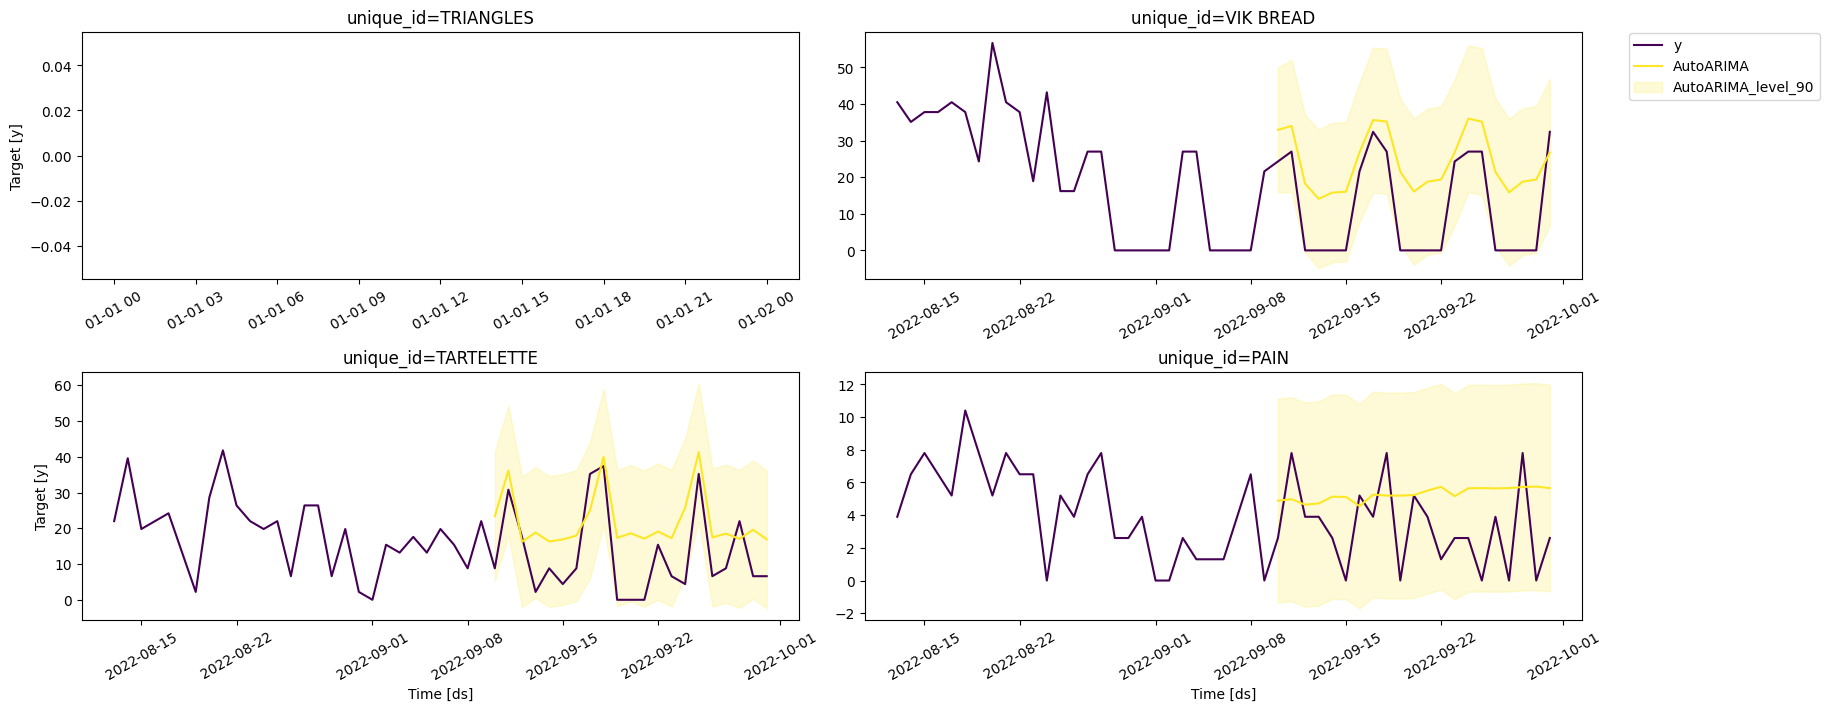

In [66]:
plot_series(df=train, 
            forecasts_df = test_df,
            ids=ids,
            max_insample_length = 28,
            models = ['AutoARIMA'],
            level = [90],
        
            palette='viridis')

In [67]:
# Run cross validation on the model 

model = [AutoARIMA(season_length = 7)]

sf = StatsForecast(models = model, freq = 'D')

#Run Cross Validation now

cv_prob_df = sf.cross_validation(
    h = horizon,
    df = small_df,
    n_windows =8,
    step_size = horizon,
    refit = True,
    level = [80]
)


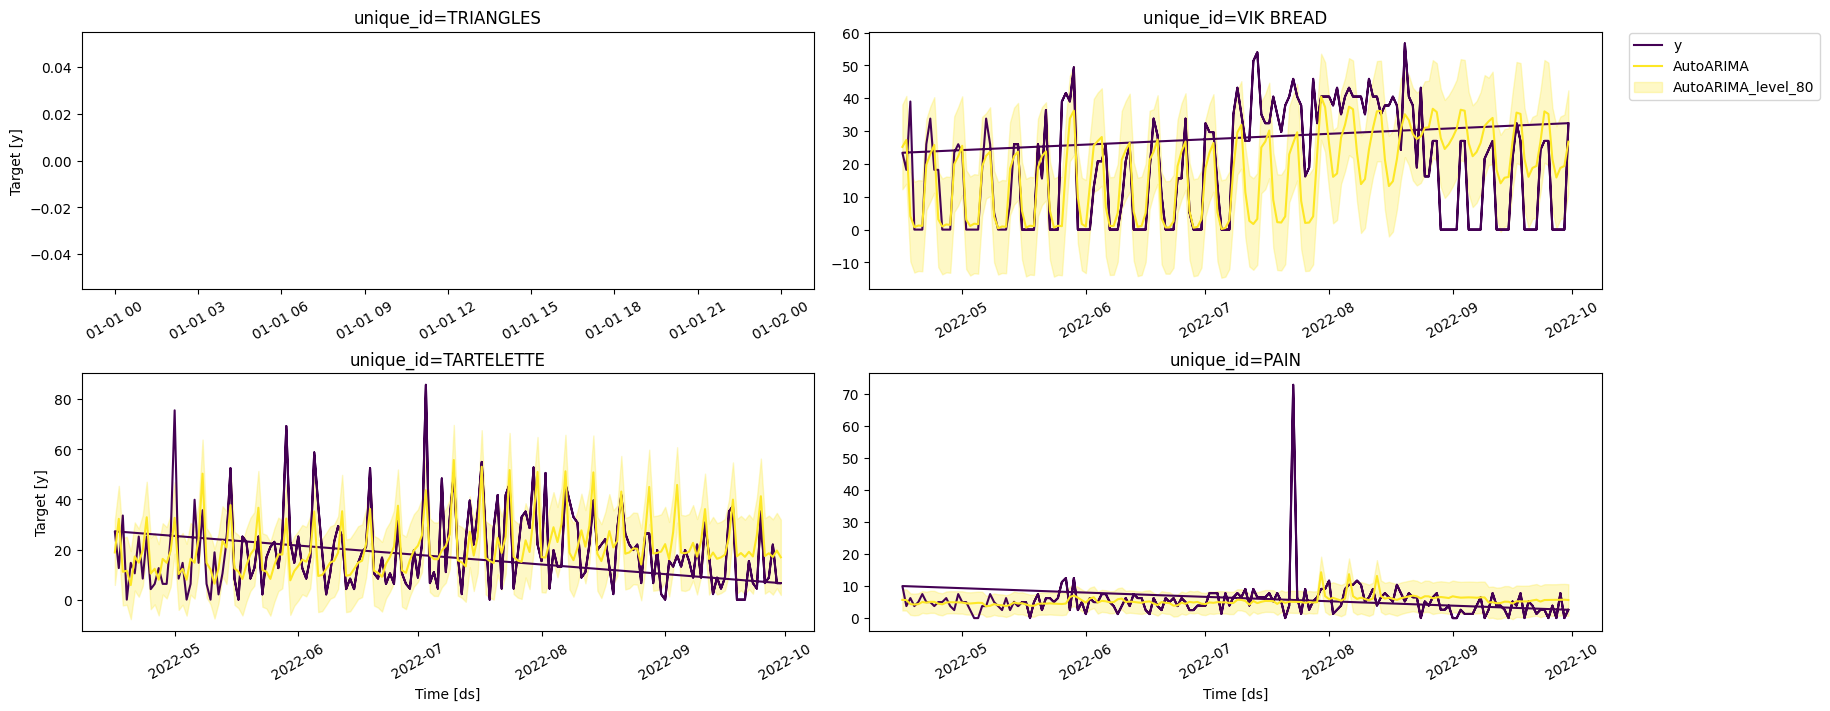

In [68]:
plot_series(df=small_df, 
            forecasts_df = cv_prob_df,
            ids=ids,
            max_insample_length = 140,
            models = ['AutoARIMA'],
            level = [80],
        
            palette='viridis')

 ### h) Evaluation Metrics

In [69]:
model = [AutoARIMA(season_length = 7, alias = "SARIMA_exog"),
        SeasonalNaive(season_length= 7)]

sf = StatsForecast(models = model, freq = 'D')

#Run Cross Validation now

final_cv_df = sf.cross_validation(
    h = horizon,
    df = small_df,
    n_windows =8,
    step_size = horizon,
    refit = True,
    level = [80]
)

In [70]:
final_cv_df.head()
 

,unique_id,ds,cutoff,y,SARIMA_exog,SARIMA_exog-lo-80,SARIMA_exog-hi-80,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
0,PAIN,2022-04-16,2022-04-15,10.00,5.678574,2.389111,8.968037,6.25,1.785702,10.714298
1,PAIN,2022-04-17,2022-04-15,3.75,5.655716,2.355215,8.956217,6.25,1.785702,10.714298
2,PAIN,2022-04-18,2022-04-15,6.25,4.372214,1.016024,7.728403,3.75,-0.714298,8.214298
3,PAIN,2022-04-19,2022-04-15,3.75,4.236955,0.851453,7.622457,2.50,-1.964298,6.964298
4,PAIN,2022-04-20,2022-04-15,5.00,4.361871,0.971929,7.751814,6.25,1.785702,10.714298


In [71]:
temp_test = small_df.groupby('unique_id').tail(21*8)
temp_train = small_df.drop(test.index).reset_index(drop=True)

In [72]:
models = ['SARIMA_exog', 'SeasonalNaive']
metrics = [
    mae,
    mse,
    rmse,
    mape,
    smape,
    partial(mase, seasonality=7),
    scaled_crps
    
]

final_eval = evaluate(
    final_cv_df.drop(["ds", "cutoff"], axis=1),
    metrics = metrics,
    models = models,
    train_df = temp_train,
    level = [80]

)
final_eval = final_eval.drop(["unique_id"], axis=1).groupby('metric').mean().reset_index()
final_eval

,metric,SARIMA_exog,SeasonalNaive
0,mae,8.095362,9.492560
1,mape,0.658332,0.860572
2,mase,1.212233,1.505135
3,mse,144.646932,233.733735
4,rmse,11.380372,14.996034
5,scaled_crps,0.261219,0.409559
6,smape,0.372199,0.341952


In [73]:
final_eval = final_eval[final_eval['metric'] != 'mse']
final_eval

,metric,SARIMA_exog,SeasonalNaive
0,mae,8.095362,9.492560
1,mape,0.658332,0.860572
2,mase,1.212233,1.505135
4,rmse,11.380372,14.996034
5,scaled_crps,0.261219,0.409559
6,smape,0.372199,0.341952


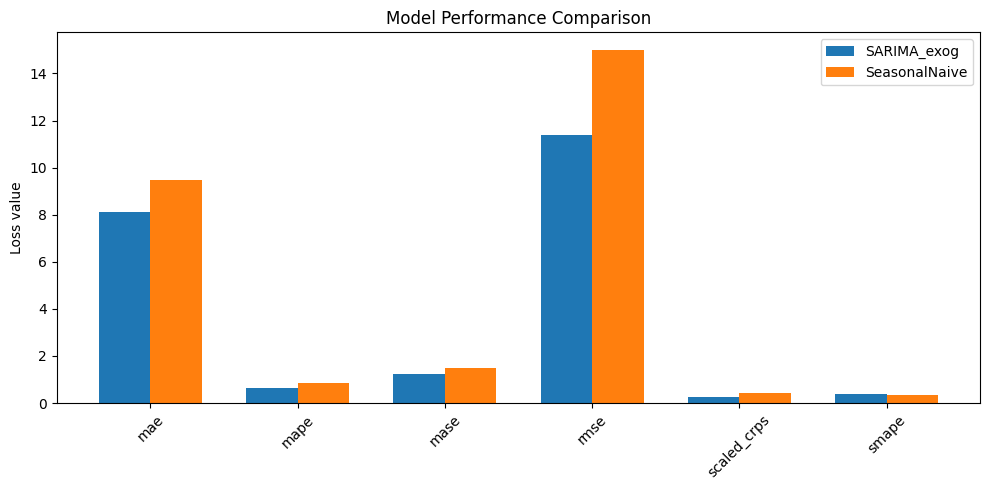

In [76]:
x = np.arange(len(final_eval['metric']))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, final_eval['SARIMA_exog'], width, label='SARIMA_exog')
plt.bar(x + width/2, final_eval['SeasonalNaive'], width, label='SeasonalNaive')

plt.xticks(x, final_eval['metric'], rotation=45)
plt.ylabel('Loss value')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()

We can conclude that SARIMA_exog performs better across all loss metrics